## Time Series Challenge
In this challenge, we will compare the various time series prediction techniques on the dataset we can find [here](https://drive.google.com/file/d/1pgZlxluv5_cbgwR5JSWu4njbYXo_06Eb/view?usp=sharing).

- moving average
- ARIMA
- Prophet
- (Stretch) LSTMs

There are several item categories in this sales dataset. You can choose your own category or predict the overall sales.

> #### Note
> We have one order in every row, thus don't forget to transform the data into a time series format first. The data can be transformed into a daily, weekly or monthly time series.

In [1]:
import pandas as pd
import sys
sys.path.append(r"C:\Users\silvh\OneDrive\lighthouse\custom_python")
from silvhua import *
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# import openpyxl

In [ ]:
# orders = pd.read_excel('./superstore.xls', engine = 'openpyxl')
# print(orders.columns)
# orders

In [9]:
orders = load_csv('superstore.csv', r'C:\Users\silvh\OneDrive\lighthouse\W09\2022-11-14-time_series_exercise', column1_as_index=True)
print(orders.shape)
orders.head(3)

(9994, 20)


,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136
2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.0,219.5820
3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.62,2,0.0,6.8714


In [11]:
for column in ['Category', 'Sub-Category']:
    print(orders[column].value_counts())

Office Supplies    6026
Furniture          2121
Technology         1847
Name: Category, dtype: int64
Binders        1523
Paper          1370
Furnishings     957
Phones          889
Storage         846
Art             796
Accessories     775
Chairs          617
Appliances      466
Labels          364
Tables          319
Envelopes       254
Bookcases       228
Fasteners       217
Supplies        190
Machines        115
Copiers          68
Name: Sub-Category, dtype: int64


In [12]:
orders[orders['Category']=='Furniture']['Sub-Category'].value_counts()

Furnishings    957
Chairs         617
Tables         319
Bookcases      228
Name: Sub-Category, dtype: int64

In [13]:
orders[orders['Category']=='Office Supplies']['Sub-Category'].value_counts()

Binders       1523
Paper         1370
Storage        846
Art            796
Appliances     466
Labels         364
Envelopes      254
Fasteners      217
Supplies       190
Name: Sub-Category, dtype: int64

In [14]:
orders[['Order Date', 'Sales']].dtypes

Order Date     object
Sales         float64
dtype: object

In [64]:
# Select Furniture sales only
data = orders[orders['Category']=='Furniture']
print(data.shape)

# Select only Order Date and Sales columns
data = pd.concat([pd.DataFrame(pd.to_datetime(data['Order Date'])), data['Sales']], axis=1)
data

(2121, 20)


,Order Date,Sales
1,2016-11-08,261.9600
2,2016-11-08,731.9400
4,2015-10-11,957.5775
6,2014-06-09,48.8600
11,2014-06-09,1706.1840
...,...,...
9963,2015-03-19,383.4656
9965,2016-12-05,13.4000
9981,2015-09-06,85.9800
9990,2014-01-21,25.2480


In [65]:
print(data['Order Date'].min())
print(data['Order Date'].max())

2014-01-06 00:00:00
2017-12-30 00:00:00


### *Look at the data, check for stationarity*

In [90]:
df = data.set_index('Order Date')
# df.index = df.index.to_period('D')
print(type(df.index))
df

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


,Sales
Order Date,
2016-11-08,261.9600
2016-11-08,731.9400
2015-10-11,957.5775
2014-06-09,48.8600
2014-06-09,1706.1840
...,...
2015-03-19,383.4656
2016-12-05,13.4000
2015-09-06,85.9800


In [107]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
def ADF_stationarity_test(timeseries, significance=0.05, model='additive', decompose=False):
    result = adfuller(timeseries)
    print(f'Statistic: {result[0]:.2f}. p-value: {result[1]:.2f}.')
    if result[1] <= significance:
        print('p-value reached level of significance. Time series is stationary.')
    else:
        print('Time series is not stationary.')
    
    if decompose:
        decompose = seasonal_decompose(timeseries, model=model)
        decompose.plot()
    return result

In [130]:
# check for stationarity
ADF_stationarity_test(df)

Statistic: -23.78. p-value: 0.00.
p-value reached level of significance. Time series is stationary.


(-23.778188911852276,
 0.0,
 2,
 2118,
 {'1%': -3.433441238483705,
  '5%': -2.862905584504915,
  '10%': -2.567496971789981},
 31965.622583211138)

### *Prophet*

In [30]:
from prophet import Prophet

In [155]:
# Take a monthly sum
data_p_monthly_sum_total = df.resample('M').sum()
data_p_monthly_sum_total.index.name=None
print(data_p_monthly_sum_total.shape)
data_p_monthly_sum_total.reset_index(inplace=True)
data_p_monthly_sum_total.columns
data_p_monthly_sum_total.columns = ['ds', 'y']
data_p_monthly_sum_total.head()

(48, 1)


,ds,y
0,2014-01-31,6242.525
1,2014-02-28,1839.658
2,2014-03-31,14573.956
3,2014-04-30,7944.837
4,2014-05-31,6912.787


In [168]:
# Split into train and test sets
data_p_monthly_sum_test = data_p_monthly_sum_total[36:]
data_p_monthly_sum = data_p_monthly_sum_total[:36]
print(data_p_monthly_sum_test.shape)
print(data_p_monthly_sum.shape)
data_p_monthly_sum.tail()

(12, 2)
(36, 2)


,ds,y
31,2016-08-31,12483.2323
32,2016-09-30,27262.8809
33,2016-10-31,11872.5770
34,2016-11-30,31783.6288
35,2016-12-31,36678.7150


In [177]:
prophet_m = Prophet()
prophet_m.fit(data_p_monthly_sum)
future_m = prophet_m.make_future_dataframe(periods=12, freq='M')
forecast_m = prophet_m.predict(future_m)
print(forecast_m.shape)

from prophet.plot import plot_plotly, plot_components_plotly
plot_plotly(prophet_m, forecast_m)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
c:\ProgramData\Anaconda3\envs\cloudEnv\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

c:\ProgramData\Anaconda3\envs\cloudEnv\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

c:\ProgramData\Anaconda3\envs\cloudEnv\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



(48, 16)


In [295]:
plot_components_plotly(prophet_m, forecast_m)

c:\ProgramData\Anaconda3\envs\cloudEnv\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [180]:
forecast_m.tail(12)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
36,2017-01-31,16730.812073,8434.814333,13087.137508,16730.809866,16730.814019,-5981.192114,-5981.192114,-5981.192114,-5981.192114,-5981.192114,-5981.192114,0.0,0.0,0.0,10749.619959
37,2017-02-28,16855.432857,3009.585196,7776.706776,16855.424329,16855.440135,-11264.057973,-11264.057973,-11264.057973,-11264.057973,-11264.057973,-11264.057973,0.0,0.0,0.0,5591.374884
38,2017-03-31,16993.405868,13442.098570,18136.609807,16993.389427,16993.421807,-1216.339447,-1216.339447,-1216.339447,-1216.339447,-1216.339447,-1216.339447,0.0,0.0,0.0,15777.066420
39,2017-04-30,17126.928136,11648.945462,16458.596245,17126.902479,17126.953202,-3194.891181,-3194.891181,-3194.891181,-3194.891181,-3194.891181,-3194.891181,0.0,0.0,0.0,13932.036955
40,2017-05-31,17264.901147,12262.194364,16930.827012,17264.862411,17264.938362,-2659.215494,-2659.215494,-2659.215494,-2659.215494,-2659.215494,-2659.215494,0.0,0.0,0.0,14605.685652
41,2017-06-30,17398.423415,12747.023169,17257.224675,17398.371357,17398.473592,-2385.633796,-2385.633796,-2385.633796,-2385.633796,-2385.633796,-2385.633796,0.0,0.0,0.0,15012.789619
42,2017-07-31,17536.396426,12913.525149,17563.125133,17536.330352,17536.462518,-2325.344496,-2325.344496,-2325.344496,-2325.344496,-2325.344496,-2325.344496,0.0,0.0,0.0,15211.051930
43,2017-08-31,17674.369437,11136.325260,15532.267913,17674.286676,17674.453057,-4408.687266,-4408.687266,-4408.687266,-4408.687266,-4408.687266,-4408.687266,0.0,0.0,0.0,13265.682171
44,2017-09-30,17807.891705,26095.601740,31085.730341,17807.790249,17807.992078,10932.149467,10932.149467,10932.149467,10932.149467,10932.149467,10932.149467,0.0,0.0,0.0,28740.041172
45,2017-10-31,17945.864716,12168.560935,17046.982759,17945.746659,17945.988124,-3377.767455,-3377.767455,-3377.767455,-3377.767455,-3377.767455,-3377.767455,0.0,0.0,0.0,14568.097261


In [182]:
forecast_m[-12:]

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
36,2017-01-31,16730.812073,8434.814333,13087.137508,16730.809866,16730.814019,-5981.192114,-5981.192114,-5981.192114,-5981.192114,-5981.192114,-5981.192114,0.0,0.0,0.0,10749.619959
37,2017-02-28,16855.432857,3009.585196,7776.706776,16855.424329,16855.440135,-11264.057973,-11264.057973,-11264.057973,-11264.057973,-11264.057973,-11264.057973,0.0,0.0,0.0,5591.374884
38,2017-03-31,16993.405868,13442.098570,18136.609807,16993.389427,16993.421807,-1216.339447,-1216.339447,-1216.339447,-1216.339447,-1216.339447,-1216.339447,0.0,0.0,0.0,15777.066420
39,2017-04-30,17126.928136,11648.945462,16458.596245,17126.902479,17126.953202,-3194.891181,-3194.891181,-3194.891181,-3194.891181,-3194.891181,-3194.891181,0.0,0.0,0.0,13932.036955
40,2017-05-31,17264.901147,12262.194364,16930.827012,17264.862411,17264.938362,-2659.215494,-2659.215494,-2659.215494,-2659.215494,-2659.215494,-2659.215494,0.0,0.0,0.0,14605.685652
41,2017-06-30,17398.423415,12747.023169,17257.224675,17398.371357,17398.473592,-2385.633796,-2385.633796,-2385.633796,-2385.633796,-2385.633796,-2385.633796,0.0,0.0,0.0,15012.789619
42,2017-07-31,17536.396426,12913.525149,17563.125133,17536.330352,17536.462518,-2325.344496,-2325.344496,-2325.344496,-2325.344496,-2325.344496,-2325.344496,0.0,0.0,0.0,15211.051930
43,2017-08-31,17674.369437,11136.325260,15532.267913,17674.286676,17674.453057,-4408.687266,-4408.687266,-4408.687266,-4408.687266,-4408.687266,-4408.687266,0.0,0.0,0.0,13265.682171
44,2017-09-30,17807.891705,26095.601740,31085.730341,17807.790249,17807.992078,10932.149467,10932.149467,10932.149467,10932.149467,10932.149467,10932.149467,0.0,0.0,0.0,28740.041172
45,2017-10-31,17945.864716,12168.560935,17046.982759,17945.746659,17945.988124,-3377.767455,-3377.767455,-3377.767455,-3377.767455,-3377.767455,-3377.767455,0.0,0.0,0.0,14568.097261


#### *Function to evaluate models*


regressor evaluation metrics: 
	Test data	Training data		Difference
RMSE: 		4216.75		3437570.33		-3433353.58
MAE: 		3763.83		1352.76		2411.06
R^2: 		0.81		0.95		-0.14

Pearson correlation between predicted and true values: 0.98 (p-value of 0.00).


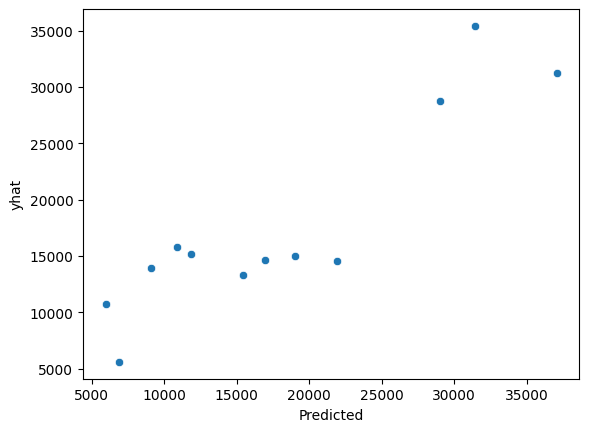

In [292]:
# function to generate evaluation metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import seaborn as sns
from scipy import stats

def evaluate_regressor(y_test, y_pred, y_train, y_pred_train, model_name='regressor',plot=True):
    """
    * Print model evalutation metrics: 
        * RMSE
        * Mean absolute error (MAE)
        * R^2 score
        * Pearson correlation coefficient
    Params:
    - plot (bool): If true, plot true vs. predicted values using test data set from train-test split.

    Returns: 
    - Evaluation metrics for train and test data subsets:
        - `.r2_train` and `.r2`
        - `.rmse_train` and `.rmse`
        - `.mean_abs_error_train` and `.mean_abs_error`
    """
    # Metrics for test data

    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mean_abs_error = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Metrics for training data

    rmse_train = mean_squared_error(y_train, y_pred_train)
    mean_abs_error_train = mean_absolute_error(y_train, y_pred_train)
    r2_train = r2_score(y_train, y_pred_train)
    
    # Calculate Pearson Correlation between predicted and true values:
    pearson = stats.pearsonr(y_train, y_pred_train)

    print(f'\n{model_name} evaluation metrics: \n\tTest data\tTraining data\t\tDifference')
    print(f'RMSE: \t\t{rmse:.2f}\t\t{rmse_train:.2f}\t\t{(rmse - rmse_train):.2f}')
    print(f'MAE: \t\t{mean_abs_error:.2f}\t\t{mean_abs_error_train:.2f}\t\t{(mean_abs_error - mean_abs_error_train):.2f}')
    print(f'R^2: \t\t{r2:.2f}\t\t{r2_train:.2f}\t\t{(r2 - r2_train):.2f}')
    print(f'\nPearson correlation between predicted and true values: {pearson.statistic:.2f} (p-value of {pearson.pvalue:.2f}).')

    if plot:
        fig = sns.scatterplot(x=y_test, y=y_pred)
        fig.set_xlabel('Predicted')

evaluate_regressor(data_p_monthly_sum_test['y'], forecast_m['yhat'][-12:], data_p_monthly_sum['y'], forecast_m['yhat'][:-12], model_name='regressor',plot=True)

### *ARIMA*

#### *Looking at the data*

In [100]:
# Take total sales each month (end of the month)
data_arima = df.resample('M').sum()
data_arima

,Sales
Order Date,
2014-01-31,6242.5250
2014-02-28,1839.6580
2014-03-31,14573.9560
2014-04-30,7944.8370
2014-05-31,6912.7870
2014-06-30,13206.1256
2014-07-31,10821.0510
2014-08-31,7320.3465
2014-09-30,23816.4808


Statistic: -4.70. p-value: 0.00.
p-value reached level of significance. Time series is stationary.


(-4.699026242828901,
 8.450793985809693e-05,
 0,
 47,
 {'1%': -3.5778480370438146,
  '5%': -2.925338105429433,
  '10%': -2.6007735310095064},
 781.9861669712573)

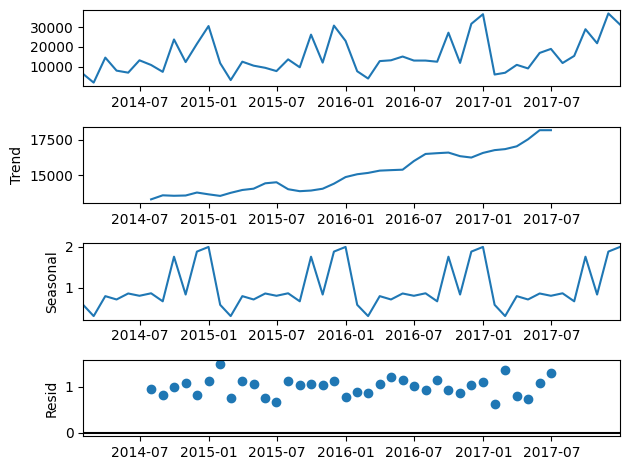

In [171]:
# check for stationarity
ADF_stationarity_test(data_arima, decompose=True, model='multiplicative') # custom function

<AxesSubplot: xlabel='Lag', ylabel='Autocorrelation'>

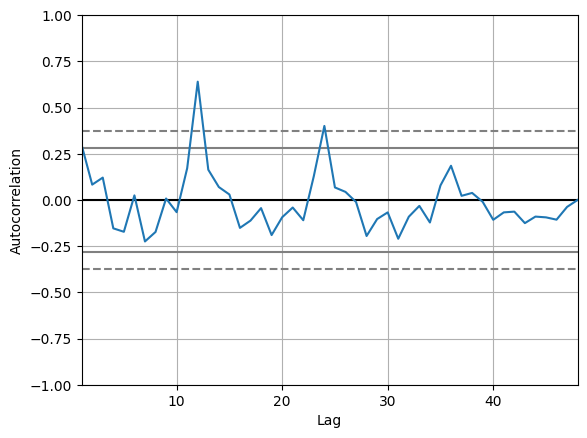

In [111]:
pd.plotting.autocorrelation_plot(data_arima)
# Looks like highest correlation with same month in the previous year

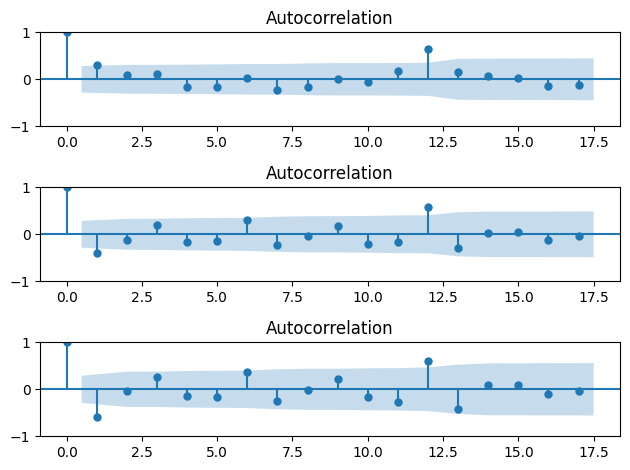

In [194]:
# Plot the autocorrelation
from statsmodels.graphics.tsaplots import plot_acf
fig, (ax1, ax2, ax3) = plt.subplots(3)
plot_acf(data_arima, ax=ax1)
plot_acf(data_arima.diff().dropna(), ax=ax2)
plot_acf(data_arima.diff().diff().dropna(), ax=ax3)
plt.tight_layout()

C:\Users\silvh\AppData\Roaming\Python\Python39\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



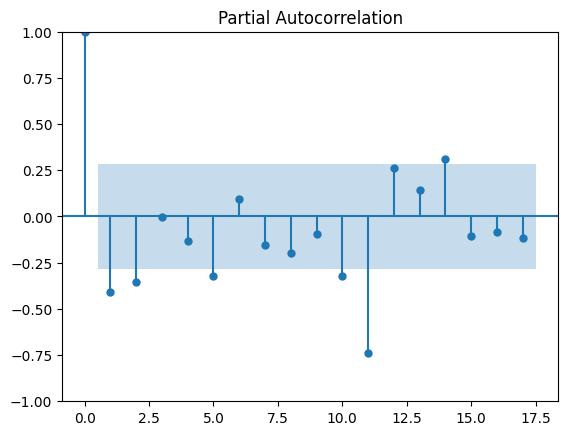

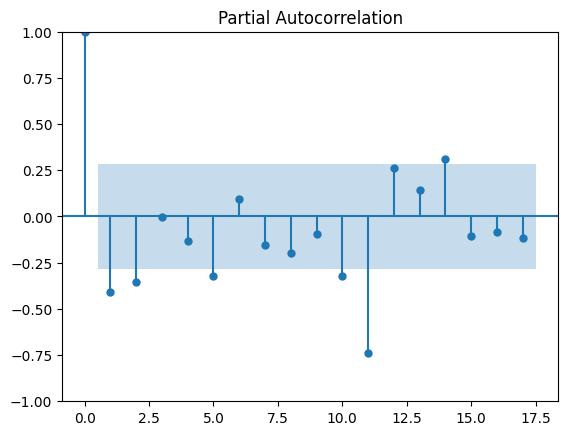

In [206]:
# Plot partial autocorrelation
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(data_arima.diff().dropna())

#### *ARIMA (1, 1, 0)*

In [195]:
from statsmodels.tsa.arima.model import ARIMA

# fit model
ar = ARIMA(data_arima, order=(1,1,0))
ar_fit = ar.fit()

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   48
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -497.558
Date:                Tue, 15 Nov 2022   AIC                            999.117
Time:                        14:55:06   BIC                           1002.817
Sample:                    01-31-2014   HQIC                          1000.509
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4011      0.128     -3.127      0.002      -0.653      -0.150
sigma2      9.366e+07   3.57e-11   2.63e+18      0.000    9.37e+07    9.37e+07
Ljung-Box (L1) (Q):                   0.86   Jarque-

<AxesSubplot: ylabel='Density'>

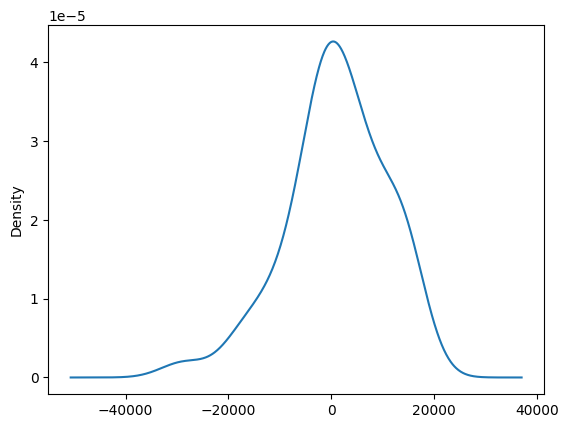

In [197]:
print(ar_fit.summary())
ar_fit.resid.plot(kind='kde')

In [200]:
ar_fit.resid.describe()

count       48.000000
mean       963.513758
std       9572.371854
min     -28751.266828
25%      -2499.457078
50%        287.835607
75%       6471.542817
max      15092.003801
dtype: float64

#### *ARIMA (1, 2, 0)*

In [201]:
# fit model
ar = ARIMA(data_arima, order=(1,2,0))
ar_fit = ar.fit()

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   48
Model:                 ARIMA(1, 2, 0)   Log Likelihood                -504.480
Date:                Tue, 15 Nov 2022   AIC                           1012.960
Time:                        15:03:55   BIC                           1016.617
Sample:                    01-31-2014   HQIC                          1014.330
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6138      0.118     -5.207      0.000      -0.845      -0.383
sigma2      1.983e+08   1.81e-10    1.1e+18      0.000    1.98e+08    1.98e+08
Ljung-Box (L1) (Q):                   5.78   Jarque-

<AxesSubplot: ylabel='Density'>

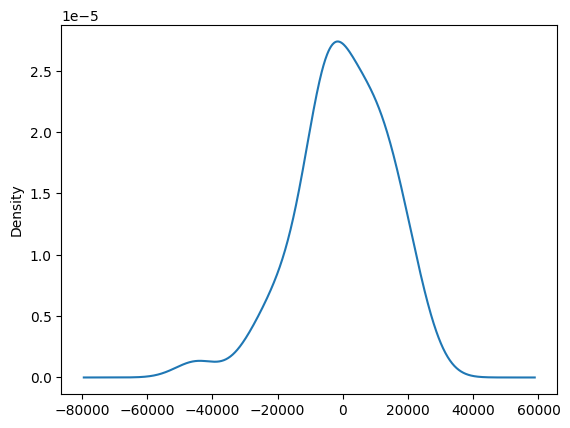

In [202]:
print(ar_fit.summary())
ar_fit.resid.plot(kind='kde')

In [203]:
ar_fit.resid.describe()
# mean is more centred than with d=1

count       48.000000
mean        76.639186
std      13931.696893
min     -44825.858425
25%      -6536.137426
50%       -176.540789
75%       9976.957594
max      24292.909938
dtype: float64

#### *ARIMA (2, 2, 0)*

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   48
Model:                 ARIMA(2, 2, 0)   Log Likelihood                -494.971
Date:                Tue, 15 Nov 2022   AIC                            995.941
Time:                        15:05:58   BIC                           1001.427
Sample:                    01-31-2014   HQIC                           997.996
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9602      0.112     -8.560      0.000      -1.180      -0.740
ar.L2         -0.5921      0.100     -5.913      0.000      -0.788      -0.396
sigma2      1.312e+08   1.25e-10   1.05e+18      0.0

<AxesSubplot: ylabel='Density'>

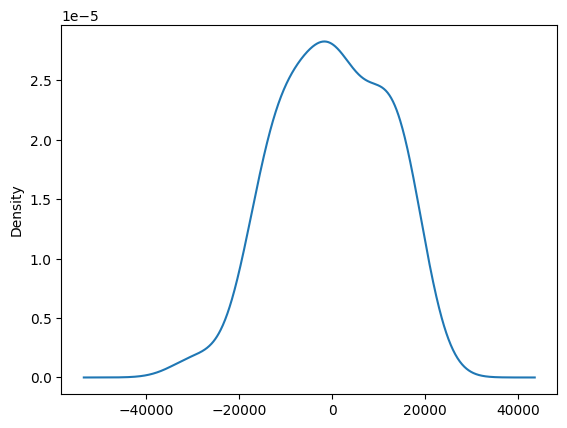

In [204]:
# fit model
ar = ARIMA(data_arima, order=(2,2,0))
ar_fit = ar.fit()
print(ar_fit.summary())
ar_fit.resid.plot(kind='kde')

In [205]:
ar_fit.resid.describe()
# Use this as final model

count       48.000000
mean        51.472726
std      11357.803940
min     -29126.366775
25%      -9127.491820
50%        326.371658
75%      10586.372642
max      19329.780407
dtype: float64

#### *ARIMA (2, 2, 2)*

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   48
Model:                 ARIMA(2, 2, 1)   Log Likelihood                -487.983
Date:                Tue, 15 Nov 2022   AIC                            983.965
Time:                        15:09:15   BIC                            991.280
Sample:                    01-31-2014   HQIC                           986.705
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5266      0.180     -2.925      0.003      -0.880      -0.174
ar.L2         -0.3184      0.206     -1.544      0.123      -0.723       0.086
ma.L1         -0.9717      0.318     -3.055      0.0

<AxesSubplot: ylabel='Density'>

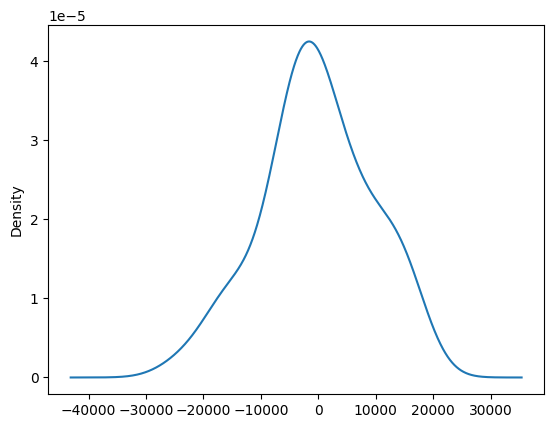

In [209]:
# fit model
ar = ARIMA(data_arima, order=(2,2,1))
ar_fit = ar.fit()
print(ar_fit.summary())
ar_fit.resid.plot(kind='kde')

In [210]:
ar_fit.resid.describe()
# Mean is now further from 0

count       48.000000
mean      -299.461954
std       9402.466994
min     -23486.758560
25%      -5454.283045
50%       -990.109617
75%       5967.556147
max      15746.828456
dtype: float64

### *ARIMA (2, 2, 0) predictions*

In [274]:
history

[6242.525000000001,
 1839.658,
 14573.956,
 7944.8369999999995,
 6912.787,
 13206.1256,
 10821.051,
 7320.3465,
 23816.4808,
 12304.247,
 21564.8727,
 30645.9665,
 11739.9416,
 3134.374,
 12499.783,
 10475.6985,
 9374.950499999999,
 7714.179,
 13674.42,
 9638.5922,
 26273.023,
 12026.6235,
 30880.8325,
 23085.8192,
 7622.743,
 3925.551]

In [279]:
# split into train and test sets
y_train = data_arima[:26]
y_test = data_arima[36:]

history = [x for x in y_train['Sales'].values]
predictions = list()
# walk-forward validation
for t in range(len(y_test)):
	model = ARIMA(history, order=(2,2,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	print(t, yhat)
	obs = y_test['Sales'][t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))


0 -7597.770704035961
predicted=-7597.770704, expected=5964.032000
1 -4919.528931487253
predicted=-4919.528931, expected=6866.337400
2 5724.97236184828
predicted=5724.972362, expected=10893.444800
3 12440.98841731916
predicted=12440.988417, expected=9065.958100
4 11347.323023951692
predicted=11347.323024, expected=16957.558200
5 18351.201084139495
predicted=18351.201084, expected=19008.586700
6 21554.478202757164
predicted=21554.478203, expected=11813.022000
7 17143.30177738127
predicted=17143.301777, expected=15441.874000
8 13461.149601782374
predicted=13461.149602, expected=29028.206000
9 26748.764860813237
predicted=26748.764861, expected=21884.068200
10 29562.523113733685
predicted=29562.523114, expected=37056.715000
11 41721.431556846466
predicted=41721.431557, expected=31407.466800


In [280]:
predictions

[-7597.770704035961,
 -4919.528931487253,
 5724.97236184828,
 12440.98841731916,
 11347.323023951692,
 18351.201084139495,
 21554.478202757164,
 17143.30177738127,
 13461.149601782374,
 26748.764860813237,
 29562.523113733685,
 41721.431556846466]

In [284]:
y_test['Sales'].values

array([ 5964.032 ,  6866.3374, 10893.4448,  9065.9581, 16957.5582,
       19008.5867, 11813.022 , 15441.874 , 29028.206 , 21884.0682,
       37056.715 , 31407.4668])

<AxesSubplot: >

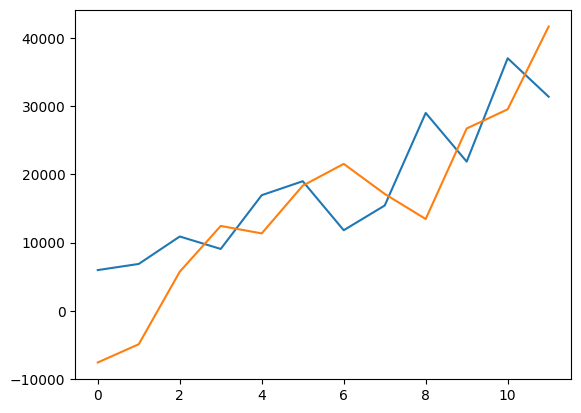

In [281]:
# fig, ax = plt.subplots(1)
sns.lineplot(y_test['Sales'].values)
sns.lineplot(predictions)


regressor evaluation metrics: 
	Test data	Training data		Difference
RMSE: 		8752.00		0.00		8752.00
MAE: 		7486.80		0.00		7486.80
R^2: 		0.18		1.00		-0.82

Pearson correlation between predicted and true values: 1.00 (p-value of 0.00).


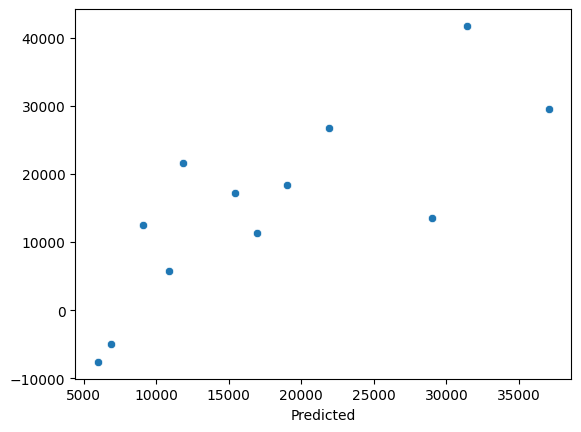

In [294]:
# Evaluate model
evaluate_regressor(y_test['Sales'].values, predictions, y_train['Sales'].values, y_train['Sales'].values, model_name='regressor',plot=True)

In [293]:
from scipy import stats
stats.pearsonr(predictions, y_test['Sales'].values)

PearsonRResult(statistic=0.7792952890872032, pvalue=0.0028086737636117834)